#Supervised methods job assignment: Adult dataset

David Galera, Gener 2023.

# Preparació

## Importació de móduls i dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from sklearn.utils import resample #downsample the dataset
from sklearn.model_selection import train_test_split #split data into training and testing datasets
from sklearn.preprocessing import StandardScaler #scale and center the data
from sklearn import svm #this will make a support vector machine for classification
from sklearn.model_selection import GridSearchCV #this will do cross validation
from sklearn.metrics import confusion_matrix #this creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix #draws a confusion matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from time import time

In [ ]:
adult = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", sep=",", header=None, skipinitialspace=True)
columns=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race',  'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
adult.columns = columns
print(adult.info())
print(adult.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov  

In [ ]:
adult.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

In [ ]:
adult.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.58,13.64,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.37,105549.98,12285.0,117827.0,178356.0,237051.0,1484705.0
education-num,32561.0,10.08,2.57,1.0,9.0,10.0,12.0,16.0
capital-gain,32561.0,1077.65,7385.29,0.0,0.0,0.0,0.0,99999.0
capital-loss,32561.0,87.30,402.96,0.0,0.0,0.0,0.0,4356.0
hours-per-week,32561.0,40.44,12.35,1.0,40.0,40.0,45.0,99.0


## Identificació i tractament de missing values

In [ ]:
adult.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

A primera vista no hi ha missing values, però si explorem les columnes categòriques veurem que estan codificats amb un **"?"**

In [ ]:
adult.workclass.value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In [ ]:
null_values = (adult == "?").sum()
print(null_values)

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64


Calculem el total d'observacions amb 1 o més missing values.

In [ ]:
len(adult.loc[(adult['workclass']=='?')|(adult['occupation']=='?')|(adult['native-country']=='?')])#també podem reemplaçar la columna country amb la moda

2399

Podem veure com 2399 de 32561 observacions, el 7.36% contenen missing values. Decidim eliminar-les de manera imparcial, ja que per alguns métodes d'aprenentatge supervisat ni tan sols farem servir la totalitat de les observacions. També es podria reemplaçar cadascún d'ells per la moda de la variable en qüestió.

In [ ]:
adult_nomissing = adult.loc[(adult['workclass']!='?')&(adult['occupation']!='?')&(adult['native-country']!='?')]
print(len(adult_nomissing))

30162


Ens quedem amb 30162 observacions que són més que suficients per SVM.

In [ ]:
adult_nomissing.income.value_counts()

<=50K    22654
>50K      7508
Name: income, dtype: int64

Transformem el target binari a 0 i 1:

In [ ]:
adult_nomissing['income'] = adult_nomissing['income'].replace(['<=50K', '>50K'], [0, 1])
print(adult_nomissing.income.value_counts())

0    22654
1     7508
Name: income, dtype: int64


<ipython-input-11-a18e07f133b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult_nomissing['income']= adult_nomissing['income'].replace(['<=50K', '>50K'], [0, 1])


## Assignació de X, y

In [ ]:
X = adult_nomissing.iloc[:, :-1]
y = adult_nomissing.iloc[:, -1]

# Gaussian Naive Bayes

Com que tenim variables continues i categòriques a la vegada, utilitzem **Gaussian Naive Bayes**.

## One Hot Encoding

Apliquem One Hot Encoding a les variables categòriques:

In [ ]:
X_onehot = pd.get_dummies(X, columns=['workclass','education','marital-status','occupation','relationship','race','sex','native-country'],drop_first=True)#one hot categorical columns

## Train, test split

Fem una partició estratificada del dataset, 20% destinat al conjunt de validació:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.2, random_state=42, stratify=y)

## Gaussian NB optimization

En GaussianNB l'estimador aprèn la mitjana i la desviació estàndar de cada variable i a l'hora de preedir, la probabilitat d'un valor de pertànyer a una classe va en funció de la seva distància al centre de la distribució. En GaussianNB la funció de densitat de probabilitat utilitzada és la d'una distribució gaussiana de mitjana 0 i variança 1, per tant no cal estandaritzar variables ja que l'estimador ho realitza internament.

La mètrica avaluada és l'**accuracy** ja que en aquest cas el que ens interessa és un model que obtingui el **màxim número d'encerts**.

Al ser un algorisme d'execució relativament ràpida, aplicarem GridSearchCV múltiples vegades variant la mida dels folds. 

Seleccionarem el model que resulti en el màxim **score** al conjunt de validació:

In [ ]:
parameters ={'var_smoothing' : np.logspace(0,-9,100)}
scores=[0]

In [ ]:
start=time()
for i in range(3,6):
  print(i)
  estimator=GridSearchCV(GaussianNB(), parameters, cv=i,scoring='accuracy',verbose=0)
  estimator.fit(X_train, y_train)
  if estimator.score(X_test, y_test)>max(scores):
    scores.append(estimator.score(X_test, y_test))
    best_model=estimator
elapsed= time() -start
print(elapsed)

3
4
5
59.447874784469604


In [ ]:
print("Accuracy del training set:", round(best_model.score(X_train, y_train)*100,2),"%")
print("Accuracy del test set:", round(best_model.score(X_test, y_test)*100,2),"%")
print(best_model.best_params_)

Accuracy del training set: 79.97 %
Accuracy del test set: 79.86 %
{'var_smoothing': 1e-05}


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


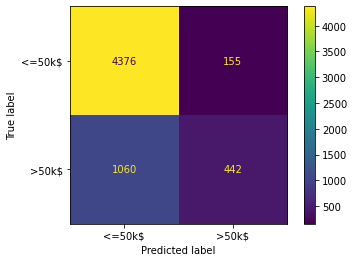

In [ ]:
plot_confusion_matrix(best_model,X_test, y_test,values_format='d',display_labels=['<=50k$','>50k$'])

## Tractament d'outliers

En aquest apartat, s'han tractat els outliers de 3 maneres diferents, desprès de cada tractament s'han tornat a executar els 3 apartats anteriors i els resultats han estat que **l'accuracy del model en el conjunt d'entrenament i de validació no ha millorat en cap dels intents**. 

Els 3 intents realitzats han estat:

- Eliminar outliers
- Substituïr outliers per la moda
- Substituïr outliers per +1.5*IQR o -1.5*IQR

El métode que ha donat millors resultats ha estat subtituïr outliers per la moda. L'accuracy del conjunt de validació ha estat del **79.84 %**, quasi idèntica a l'obtinguda **sense tractar outliers del 79.86%**.


In [ ]:
def outlier_detector(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn,[25,75])
    IQR = Q3 - Q1
    lower_bound = Q1-(1.5*IQR)
    upper_bound = Q3+(1.5*IQR)
    return lower_bound,upper_bound

In [ ]:
numeric = ['age', 'fnlwgt', 'education-num', 'hours-per-week']

Intent 1: Eliminació d'outliers

In [ ]:
index=[]
for i in numeric:
  lowerbound, upperbound = outlier_detector(adult_nomissing[i])
  index.append(adult_nomissing.index[(adult_nomissing[i]>upperbound)|(adult_nomissing[i]<lowerbound)].to_list())
flat_index = [item for sublist in index for item in sublist]
print("Número d'outliers:",len(set(flat_index)))

Número d'outliers: 8834


In [ ]:
adult_nomissing.drop(flat_index, axis=0,inplace=True)
adult_nomissing.reset_index(inplace=True)
print(adult_nomissing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21328 entries, 0 to 21327
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           21328 non-null  int64 
 1   age             21328 non-null  int64 
 2   workclass       21328 non-null  object
 3   fnlwgt          21328 non-null  int64 
 4   education       21328 non-null  object
 5   education-num   21328 non-null  int64 
 6   marital-status  21328 non-null  object
 7   occupation      21328 non-null  object
 8   relationship    21328 non-null  object
 9   race            21328 non-null  object
 10  sex             21328 non-null  object
 11  capital-gain    21328 non-null  int64 
 12  capital-loss    21328 non-null  int64 
 13  hours-per-week  21328 non-null  int64 
 14  native-country  21328 non-null  object
 15  income          21328 non-null  int64 
dtypes: int64(8), object(8)
memory usage: 2.6+ MB
None


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Intent 2: Reemplaçar outliers per la moda

In [ ]:
for i in numeric:
    lowerbound, upperbound = outlier_detector(adult_nomissing[i])
    median = adult_nomissing[i].median()
    adult_nomissing.loc[((adult_nomissing[i] > upperbound)|(adult_nomissing[i] < lowerbound)), i] = median

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Intent 3: Reemplaçar outliers per 1.5 vegades la distància interquartil

In [ ]:
for i in numeric:
    lowerbound, upperbound = outlier_detector(adult_nomissing[i])
    adult_nomissing.loc[(adult_nomissing[i] > upperbound), i] = upperbound
    adult_nomissing.loc[(adult_nomissing[i] < lowerbound), i] = lowerbound

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


# KNN

## Label encoding

In [ ]:
categorical = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']

In [ ]:
label_encoder = LabelEncoder()
X_label=X.copy()
for i in categorical:
    X_label[i] = label_encoder.fit_transform(X[i])
X_label.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38
1,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
2,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
3,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
4,28,2,338409,9,13,2,9,5,2,0,0,0,40,4


In [ ]:
X_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             30162 non-null  int64
 1   workclass       30162 non-null  int64
 2   fnlwgt          30162 non-null  int64
 3   education       30162 non-null  int64
 4   education-num   30162 non-null  int64
 5   marital-status  30162 non-null  int64
 6   occupation      30162 non-null  int64
 7   relationship    30162 non-null  int64
 8   race            30162 non-null  int64
 9   sex             30162 non-null  int64
 10  capital-gain    30162 non-null  int64
 11  capital-loss    30162 non-null  int64
 12  hours-per-week  30162 non-null  int64
 13  native-country  30162 non-null  int64
dtypes: int64(14)
memory usage: 3.5 MB


## Train, test split

Fem una partició estratificada del dataset, 20% destinat al conjunt de validació:

In [ ]:
X_label_train, X_label_test, y_label_train, y_label_test = train_test_split(X_label, y, test_size=0.2, random_state=42, stratify=y)

## Escalat de dades

Un cop transformades les variables categòriques i realitzada la partició, procedim a normalitzar les númeriques, ja que tots els algorismes basats en distàncies funcionen millor quan les variables tenen el mateix rang de valors i aquests són petits. 

Aquí es poden provar varis métodes, en aquest cas utilitzarem MinMaxScaler però també es podrien fer proves amb MaxAbsScaler per exemple.

In [ ]:
sc = MinMaxScaler()
scaler = sc.fit(X_label_train)

In [ ]:
X_label_train_sc = pd.DataFrame(scaler.transform(X_label_train.values),columns=columns[:-1], index=X_label_train.index)
X_label_test_sc = pd.DataFrame(scaler.transform(X_label_test.values),columns=columns[:-1], index=X_label_test.index)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
X_label_train_sc.describe().T

,count,mean,std,min,25%,50%,75%,max
age,24129.0,0.294257,0.179266,0.0,0.150685,0.273973,0.410959,1.0
workclass,24129.0,0.366488,0.159772,0.0,0.333333,0.333333,0.333333,1.0
fnlwgt,24129.0,0.122355,0.073491,0.0,0.072228,0.114229,0.155431,1.0
education,24129.0,0.688364,0.254493,0.0,0.600000,0.733333,0.800000,1.0
education-num,24129.0,0.608300,0.170383,0.0,0.533333,0.600000,0.800000,1.0
marital-status,24129.0,0.428205,0.249822,0.0,0.333333,0.333333,0.666667,1.0
occupation,24129.0,0.460200,0.309694,0.0,0.153846,0.461538,0.692308,1.0
relationship,24129.0,0.281097,0.319048,0.0,0.000000,0.200000,0.600000,1.0
race,24129.0,0.919972,0.207897,0.0,1.000000,1.000000,1.000000,1.0
sex,24129.0,0.676157,0.467951,0.0,0.000000,1.000000,1.000000,1.0


In [ ]:
X_label_test_sc.describe().T

,count,mean,std,min,25%,50%,75%,max
age,6033.0,0.291322,0.182544,0.000000,0.150685,0.273973,0.410959,1.000000
workclass,6033.0,0.366816,0.155821,0.000000,0.333333,0.333333,0.333333,1.000000
fnlwgt,6033.0,0.121070,0.072453,0.004262,0.071179,0.114154,0.154559,1.020303
education,6033.0,0.691132,0.252797,0.000000,0.600000,0.733333,0.800000,1.000000
education-num,6033.0,0.607238,0.168469,0.000000,0.533333,0.600000,0.800000,1.000000
marital-status,6033.0,0.437289,0.248947,0.000000,0.333333,0.333333,0.666667,1.000000
occupation,6033.0,0.451453,0.310983,0.000000,0.153846,0.461538,0.692308,1.000000
relationship,6033.0,0.293950,0.324923,0.000000,0.000000,0.200000,0.600000,1.000000
race,6033.0,0.918366,0.211782,0.000000,1.000000,1.000000,1.000000,1.000000
sex,6033.0,0.673794,0.468862,0.000000,0.000000,1.000000,1.000000,1.000000


## KNN hiperparameter tunning

Farem servir dos mètodes de selecció d'hiperaparàmetres:

**Primer métode:** Per una banda aplicarem GridSearchCV en el conjunt d'entrenament amb 5 folds. I avaluarem l'accuracy del model en el conjunt de validació.

In [ ]:
parameters = {'metric':['manhattan','euclidean','cityblock','cosine','harvesine'],'n_neighbors': np.arange(2, 30), 'weights':['uniform','distance']}

In [ ]:
start=time()
estimator=GridSearchCV(KNeighborsClassifier(), parameters, cv=5,scoring='accuracy',verbose=0)
estimator.fit(X_label_train_sc, y_label_train)
elapsed= time() -start
print(elapsed)

1303.2835614681244


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
280 fits failed out of a total of 1400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
280 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py", line 198, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_base.py", line 437, in _fit
    self._check_algorithm_metric()
  File "/usr/local/lib/python3.8/dist-packages/sklearn/

In [ ]:
print("Accuracy del training set:", round(estimator.score(X_label_train_sc,y_label_train)*100,2),"%")
print("Accuracy del test set:", round(estimator.score(X_label_test_sc,y_label_test)*100,2),"%")
print(estimator.best_params_)

Accuracy del training set: 84.79 %
Accuracy del test set: 82.89 %
{'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'uniform'}


Millora el resultat obtingut amb el Gaussian NB superant el 80% d'accuracy.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


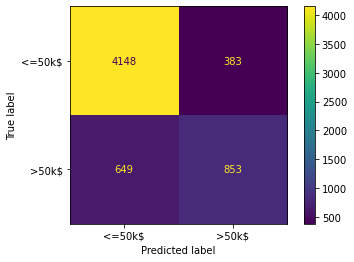

In [ ]:
plot_confusion_matrix(estimator,X_label_test_sc,y_label_test,values_format='d',display_labels=['<=50k$','>50k$'])

**Segon métode:** No utilitzem validació creuada sinó que instanciem un estimador KNN amb els hiperparàmetres per defecte excepte n_neighbors que l'anirem iterant per tots els nombres senars entre 1 i 50. En cada iteració ajustem l'estimador al conjunt d'entrenament i avaluem l'accuracy al conjunt de validació. Mesurarem l'error i seleccionarem l'hiperparàmetre que menor error tingui.

In [ ]:
error = []
k_values = list(filter(lambda x: x%2==1, range(0,50)))
best_k = 0
for i in k_values:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_label_train_sc, y_label_train)
    pred_i = knn.predict(X_label_test_sc)
    error.append(np.mean(pred_i != y_label_test))
print(error.index(np.min(error)))

15


Veiem que la iteració número 15 és la que dóna menys error. Com que és la quinzena iteració i només hem iterat números senars, aquesta iteració correspon a 15*2+1=31 n_neighbors. Si grafiquem l'error:

Text(0, 0.5, 'Error Rate')

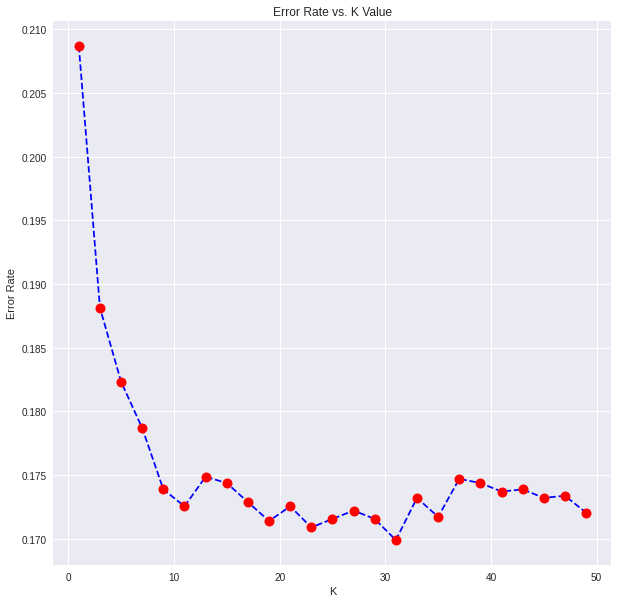

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=(10,10))
plt.plot(k_values,error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

Podem veure com **l'error mínim es produeix amb n_neighbors = 31**.

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=31)
knn_classifier.fit(X_label_train_sc, y_label_train)
knn_train_score = knn_classifier.score(X_label_train_sc, y_label_train)
knn_test_score = knn_classifier.score(X_label_test_sc,y_label_test)
print("Accuracy del training set:", round(knn_train_score*100,2),"%")
print("Accuracy del test set:", round(knn_test_score*100,2),"%")

Accuracy del training set: 84.1 %
Accuracy del test set: 83.01 %


# SVM

SVM funcionen molt bé en datasets de tamany petit però no tant amb els de major tamany com és el cas que ens ocupa. Aquest dataset és prou gran com per a que el model tardi molt de temps per optimitzar-se via CV. Així que farem un downsampling a 5000 instàncies, 2500 de cada classe:

## Downsampling

Procedim a fer un downsampling del dataset amb un 50% d'observacions de cada classe.

In [ ]:
n_samples=2500

In [ ]:
adult_nomissing_rich=adult_nomissing[adult_nomissing.income==1]
adult_nomissing_poor=adult_nomissing[adult_nomissing.income==0]

In [ ]:
adult_nomissing_rich_down=resample(adult_nomissing_rich,replace=False,n_samples=n_samples,random_state=42)
adult_nomissing_poor_down=resample(adult_nomissing_poor,replace=False,n_samples=n_samples,random_state=42)


In [ ]:
adult_nomissing_down=pd.concat([adult_nomissing_rich_down,adult_nomissing_poor_down])

## Assignació de X, y i One Hot Encoding

In [ ]:
X_down = adult_nomissing_down.iloc[:, :-1]
y_down = adult_nomissing_down.iloc[:, -1]

SVM no soporten variables categòriques, apliquem One Hot Encoding:

In [ ]:
X_down_encoded = pd.get_dummies(X_down, columns=categorical,drop_first=True)#one hot categorical columns


## Train, test split

Fem una partició estratificada del dataset, 20% destinat al conjunt de validació:

In [ ]:
X_SVM_train, X_SVM_test, y_SVM_train, y_SVM_test = train_test_split(X_down_encoded, y_down, test_size=0.2, random_state=42, stratify=y_down)

## Centering and scaling

Els kernels que utilitzarem assumeixen que les dades estan estandaritzades, cada columna numèrica ha de tenir mitjana 0 i desviació estàndar 1.

Definim una funció per estandaritzar les variables númeriques dels conjunts d'entrenament i validació amb StandardScaler ajustat al conjunt d'entrenament.

In [ ]:
def standardize(X_train, X_test, numeric):
   
    # Step 1
    sc = StandardScaler()
    
    # Step 2
    X_train_numeric = X_train[numeric]
    X_test_numeric = X_test[numeric]
    
    # Step 3
    scaler = sc.fit(X_train_numeric)
    
    # Step 4

    X_SVM_train_st = scaler.transform(X_train_numeric)
    X_SVM_test_st = scaler.transform(X_test_numeric)
    
    # Step 5

    return X_SVM_train_st, X_SVM_test_st

Executem l'estandarització:

In [ ]:
numeric = X_SVM_train.select_dtypes(include = ['int64']).columns.tolist()#localitzem les variables numèriques
X_SVM_train_numeric, X_SVM_test_numeric = standardize(X_SVM_train, X_SVM_test, numeric)


In [ ]:
print(X_SVM_train_numeric.mean(axis=0)) #Comprovem l'estandarització
print(X_SVM_train_numeric.std(axis=0))

[ 2.25153229e-16 -8.34887715e-17 -2.98427949e-16 -7.10542736e-18
  4.61852778e-17  1.11910481e-16]
[1. 1. 1. 1. 1. 1.]


StandardScaler ens retorna un *array*, definim una funció per implantar les variables estandaritzades als seus respectius conjunts:

In [ ]:
def merge(X_train, X_test, X_train_numeric, X_test_numeric, numeric):

    if X_train.shape == (0, 0): return pd.DataFrame([0]), pd.DataFrame([0])
    
    X_train_st_df = X_train.copy()
    X_train_st_df[numeric] = X_train_numeric
    X_test_st_df = X_test.copy()
    X_test_st_df[numeric] = X_test_numeric
    
    return X_train_st_df, X_test_st_df

In [ ]:
X_SVM_train_st, X_SVM_test_st = merge(X_SVM_train, X_SVM_test, X_SVM_train_numeric, X_SVM_test_numeric, numeric)


In [ ]:
print(X_SVM_train_st.head().T)

                                   8854      993       215       31225  \
age                            -0.258051  0.554708 -0.258051 -1.802292   
fnlwgt                         -0.041207  0.014681  4.211096 -1.479567   
education-num                  -0.646539 -0.646539  0.896053 -0.646539   
capital-gain                    1.290101 -0.197486 -0.197486 -0.197486   
capital-loss                   -0.259232 -0.259232 -0.259232 -0.259232   
...                                  ...       ...       ...       ...   
native-country_Thailand         0.000000  0.000000  0.000000  0.000000   
native-country_Trinadad&Tobago  0.000000  0.000000  0.000000  0.000000   
native-country_United-States    1.000000  1.000000  1.000000  1.000000   
native-country_Vietnam          0.000000  0.000000  0.000000  0.000000   
native-country_Yugoslavia       0.000000  0.000000  0.000000  0.000000   

                                   19785  
age                            -0.826982  
fnlwgt                   

In [ ]:
X_SVM_train_st.dtypes

age                               float64
fnlwgt                            float64
education-num                     float64
capital-gain                      float64
capital-loss                      float64
                                   ...   
native-country_Thailand             uint8
native-country_Trinadad&Tobago      uint8
native-country_United-States        uint8
native-country_Vietnam              uint8
native-country_Yugoslavia           uint8
Length: 94, dtype: object

## Preliminar SVM

Amb les dades formatejades construïm un classificador SVM preliminar:

In [ ]:
clf_svm = svm.SVC(random_state=42)
clf_svm.fit(X_SVM_train_st, y_SVM_train)
clf_svm.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
print("Obtenim un",round(clf_svm.score(X_SVM_train_st, y_SVM_train)*100,2),"% d'accuracy en el training set")

Obtenim un 84.98 % d'accuracy en el training set


In [ ]:
print("Obtenim un",round(clf_svm.score(X_SVM_test_st, y_SVM_test)*100,2),"% d'accuracy en el test set")

Obtenim un 82.8 % d'accuracy en el test set


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


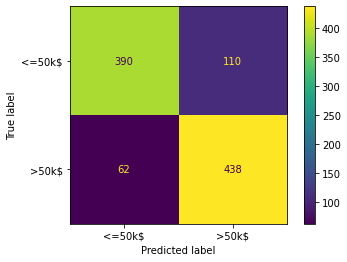

In [ ]:
plot_confusion_matrix(clf_svm,X_SVM_test_st,y_SVM_test,values_format='d',display_labels=['<=50k$','>50k$'])

## SVM optimization

L'objectiu és optimitzar una SVM ajustant hiperparàmetres. Com que el temps de computació és molt alt ajustarem els diferents hiperparàmetres per a cada kernel per separat.
Utilitzarem dos mètodes.

Per una banda aplicarem GridSearchCV al conjunt d'entrenament amb 5 folds. Posteriorment avaluem l'accuracy al conjunt de validació.

La segona metodologia no utilitza validació creuada sinó que crea una instància de l’estimador, l’ajusta al conjunt d’entrenament i avalua l’accuracy al conjunt de validació. Realitza aquests passos per totes les combinacions possibles dels hiperparàmetres especificats, mitjançant iteració. Finalment seleccionem el model amb més accuracy. 

**LinearSVC:**

Regularització L2 (Ridge)

In [ ]:
parameters ={'C' : [0.1,0.5,1, 10, 100], 'loss' : ['hinge','squared_hinge']}
scores=[0]

In [ ]:
start=time()
estimator=GridSearchCV(svm.LinearSVC(random_state=0,max_iter=10000000), parameters, cv=5,scoring='accuracy',verbose=0)
estimator.fit(X_SVM_train_st, y_SVM_train)
elapsed= time() -start
print(elapsed)

340.5304458141327


In [ ]:
print("Accuracy del training set:", round(estimator.score(X_SVM_train_st,y_SVM_train)*100,2),"%")
print("Accuracy del test set:", round(estimator.score(X_SVM_test_st,y_SVM_test)*100,2),"%")
print(estimator.best_params_)

Accuracy del training set: 83.075 %
Accuracy del test set: 83.2 %
{'C': 0.1, 'loss': 'squared_hinge'}


Hem millorat només un 0.4% l'accuracy del test set.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


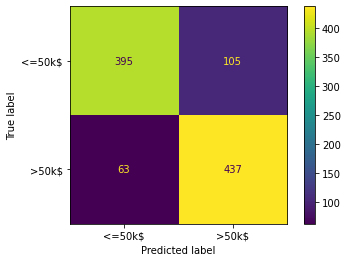

In [ ]:
plot_confusion_matrix(estimator,X_SVM_test_st,y_SVM_test,values_format='d',display_labels=['<=50k$','>50k$'])

Provem el segon mètode:

In [ ]:
C = [0.1,0.5,1, 10, 100]
loss = ['hinge','squared_hinge']
scores=[0]
d={}

In [ ]:
start=time()

for i in loss:
  print(i)
  for c in C:
    model=svm.LinearSVC(random_state=0,loss=i,C=c,max_iter=10000000)
    model.fit(X_SVM_train_st, y_SVM_train)
    if model.score(X_SVM_test_st, y_SVM_test)>max(scores):
        scores.append(model.score(X_SVM_test_st, y_SVM_test))
        d[i]=model.score(X_SVM_test_st, y_SVM_test)
        best_model=model

elapsed= time() -start
print(elapsed)

hinge
squared_hinge
120.85604453086853


In [ ]:
print("Accuracy del training set:", model.score(X_SVM_train_st,y_SVM_train)*100,"%")
print("Accuracy del test set:", model.score(X_SVM_test_st,y_SVM_test)*100,"%")

Accuracy del training set: 83.25 %
Accuracy del test set: 83.2 %


L'accuracy millora amb prou feines 2 dècimes en el training set però és manté idèntica en el test set.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


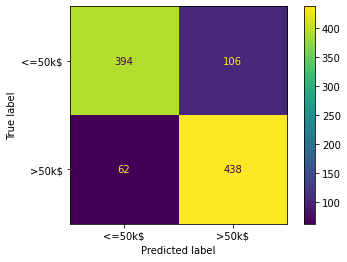

In [ ]:
plot_confusion_matrix(model,X_SVM_test_st,y_SVM_test,values_format='d',display_labels=['<=50k$','>50k$'])

Regularització L1 (Lasso)

In [ ]:
parameters ={'C' : [0.1,0.5,1, 10, 100]}

In [ ]:
start=time()
estimator=GridSearchCV(svm.LinearSVC(penalty='l1',random_state=0,dual=False,max_iter=10000000), parameters, cv=5,scoring='accuracy',verbose=0)
estimator.fit(X_SVM_train_st, y_SVM_train)
elapsed= time() -start
print(elapsed)

25.305375337600708


In [ ]:
print("Accuracy del training set:", round(estimator.score(X_SVM_train_st,y_SVM_train)*100,2),"%")
print("Accuracy del test set:", round(estimator.score(X_SVM_test_st,y_SVM_test)*100,2),"%")
print(estimator.best_params_)

Accuracy del training set: 83.12 %
Accuracy del test set: 83.4 %
{'C': 0.5}


L'accuracy millora un 0.2% al test set i empitjora un 0.1% al training set. Aquest resulta ser **el millor model SVM.**

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


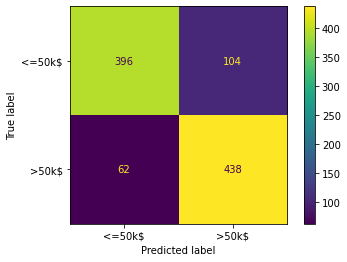

In [ ]:
plot_confusion_matrix(estimator,X_SVM_test_st,y_SVM_test,values_format='d',display_labels=['<=50k$','>50k$'])

In [ ]:
C = [0.1,0.5,1, 10, 100]
scores=[0]
d={}

In [ ]:
start=time()

for c in C:
  print(c)
  model=svm.LinearSVC(penalty='l1',random_state=0,C=c,max_iter=10000000,dual=False)
  model.fit(X_SVM_train_st, y_SVM_train)
  if model.score(X_SVM_test_st, y_SVM_test)>max(scores):
      scores.append(model.score(X_SVM_test_st, y_SVM_test))
      d[i]=model.score(X_SVM_test_st, y_SVM_test)
      best_model=model

elapsed= time() -start
print(elapsed)

0.1
0.5
1
10
100
6.941392183303833


In [ ]:
print("Accuracy del training set:", round(model.score(X_SVM_train_st,y_SVM_train)*100,2),"%")
print("Accuracy del test set:", round(model.score(X_SVM_test_st,y_SVM_test)*100,2),"%")

Accuracy del training set: 83.275 %
Accuracy del test set: 83.1 %


El model no millora amb aquesta última tècnica.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


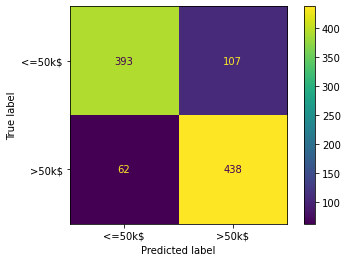

In [ ]:
plot_confusion_matrix(model,X_SVM_test_st,y_SVM_test,values_format='d',display_labels=['<=50k$','>50k$'])

**RBF**:

In [ ]:
parameters ={'gamma':['scale','auto',1,0.1,0.01,0.001,0.0001],'C' : [0.1,0.5,1, 10, 100]}

In [ ]:
start=time()
estimator=GridSearchCV(svm.SVC(), parameters, cv=5,scoring='accuracy',verbose=0)
estimator.fit(X_SVM_train_st, y_SVM_train)
elapsed= time() -start
print(elapsed)

180.12516927719116


In [ ]:
print("Accuracy del training set:", round(estimator.score(X_SVM_train_st,y_SVM_train)*100,2),"%")
print("Accuracy del test set:", round(estimator.score(X_SVM_test_st,y_SVM_test)*100,2),"%")
print(estimator.best_params_)

Accuracy del training set: 86.02 %
Accuracy del test set: 82.0 %
{'C': 100, 'gamma': 0.01}


No millora l'accuracy del test set. S'aprecia més overfitting que amb els altres kernels.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


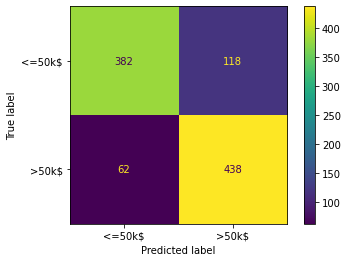

In [ ]:
plot_confusion_matrix(estimator,X_SVM_test_st,y_SVM_test,values_format='d',display_labels=['<=50k$','>50k$'])

In [ ]:
gamma = ['scale','auto',1,0.1,0.01,0.001,0.0001]
C = [0.1,0.5,1, 10, 100]
scores=[0]
d={}

In [ ]:
start=time()

for i in gamma:
  print(i)
  for c in C:
    model=svm.SVC(kernel='rbf',random_state=0,gamma=i,C=c)
    model.fit(X_SVM_train_st, y_SVM_train)
    if model.score(X_SVM_test_st, y_SVM_test)>max(scores):
        scores.append(model.score(X_SVM_test_st, y_SVM_test))
        d[i]=model.score(X_SVM_test_st, y_SVM_test)
        best_model=model

elapsed= time() -start
print(elapsed)

scale
auto
1
0.1
0.01
0.001
0.0001
66.99364733695984


In [ ]:
print("Accuracy del training set:", round(best_model.score(X_SVM_train_st,y_SVM_train)*100,2),"%")
print("Accuracy del test set:", round(best_model.score(X_SVM_test_st,y_SVM_test)*100,2),"%")

Accuracy del training set: 84.98 %
Accuracy del test set: 82.8 %


Per ara el millor SVM continua essent el lineal amb regularització L1.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


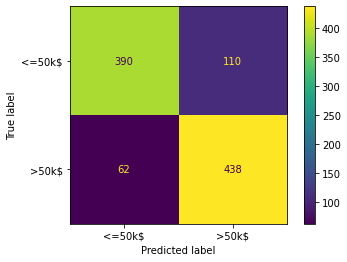

In [ ]:
plot_confusion_matrix(best_model,X_SVM_test_st,y_SVM_test,values_format='d',display_labels=['<=50k$','>50k$'])

**SIGMOID:**

In [ ]:
parameters ={'gamma':['scale','auto',1,0.1,0.01,0.001,0.0001],'C' : [0.1,0.5,1, 10, 100]}

In [ ]:
start=time()
estimator=GridSearchCV(svm.SVC(kernel='sigmoid'), parameters, cv=5,scoring='accuracy',verbose=0)
estimator.fit(X_SVM_train_st, y_SVM_train)
elapsed= time() -start
print(elapsed)

178.22076892852783


In [ ]:
print("Accuracy del training set:", round(estimator.score(X_SVM_train_st,y_SVM_train)*100,2),"%")
print("Accuracy del test set:", round(estimator.score(X_SVM_test_st,y_SVM_test)*100,2),"%")
print(estimator.best_params_)

Accuracy del training set: 81.9 %
Accuracy del test set: 82.4 %
{'C': 10, 'gamma': 'auto'}


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


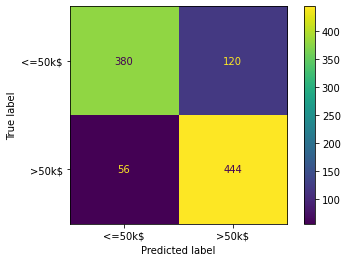

In [ ]:
plot_confusion_matrix(estimator,X_SVM_test_st,y_SVM_test,values_format='d',display_labels=['<=50k$','>50k$'])

In [ ]:
gamma = ['scale','auto',1,0.1,0.01,0.001,0.0001]
C = [0.1,0.5,1, 10, 100]
scores=[0]
d={}

In [ ]:
start=time()

for i in gamma:
  print(i)
  for c in C:
    model=svm.SVC(kernel='sigmoid',random_state=0,gamma=i,C=c)
    model.fit(X_SVM_train_st, y_SVM_train)
    if model.score(X_SVM_test_st, y_SVM_test)>max(scores):
        scores.append(model.score(X_SVM_test_st, y_SVM_test))
        d[i]=model.score(X_SVM_test_st, y_SVM_test)
        best_model=model

elapsed= time() -start
print(elapsed)

scale
auto
1
0.1
0.01
0.001
0.0001
52.72753310203552


In [ ]:
print("Accuracy del training set:", round(best_model.score(X_SVM_train_st,y_SVM_train)*100,2),"%")
print("Accuracy del test set:", round(best_model.score(X_SVM_test_st,y_SVM_test)*100,2),"%")

Accuracy del training set: 82.0 %
Accuracy del test set: 82.5 %


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


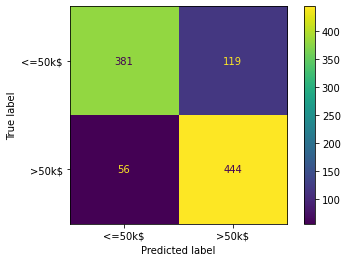

In [ ]:
plot_confusion_matrix(best_model,X_SVM_test_st,y_SVM_test,values_format='d',display_labels=['<=50k$','>50k$'])

**POLYNOMIAL:**

In [ ]:
parameters ={'gamma':['scale','auto',1,0.1,0.01,0.001,0.0001],'C' : [0.1,0.5,1, 10, 100]}
degree = np.arange(1,3)

In [ ]:
start=time()
for d in degree:
  estimator=GridSearchCV(svm.SVC(kernel='poly',degree=d), parameters, cv=5,scoring='accuracy',verbose=0)
  estimator.fit(X_SVM_train_st, y_SVM_train)
elapsed= time() -start
print(elapsed)

2445.7261888980865


Tot i fer downsample del dataset el temps d'ajust del kernel polynomic ha estat de 40 minuts.

In [ ]:
print("Accuracy del training set:", round(estimator.score(X_SVM_train_st,y_SVM_train)*100,2),"%")
print("Accuracy del test set:", round(estimator.score(X_SVM_test_st,y_SVM_test)*100,2),"%")
print(estimator.best_params_)

Accuracy del training set: 84.7 %
Accuracy del test set: 82.6 %
{'C': 1, 'gamma': 0.1}


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


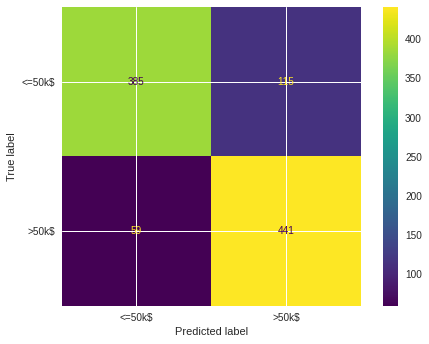

In [ ]:
plot_confusion_matrix(estimator,X_SVM_test_st,y_SVM_test,values_format='d',display_labels=['<=50k$','>50k$'])

## Feature engineering

A l’haver aplicat one-hot-encoding estem treballant amb un dataset amb 94 variables per instancia. Calculem el percentatge de variança explicada pels components principals i s’observa que aproximadament 40 PC expliquen més del 95% de variança, per tant com a últim experiment aplicarem reducció de dimensionalitat mitjançant PCA i repetirem les proves realitzades als kernels amb GridSearchCV. 

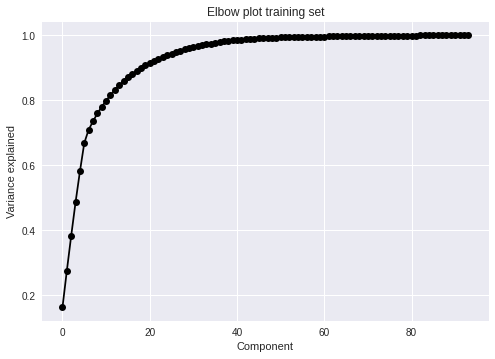

In [ ]:
pca = PCA()
pca.fit_transform(X_SVM_train_st)
plt.style.use('seaborn')
features = range(pca.n_components_)
_, ax = plt.subplots()
ax.plot(features, pca.explained_variance_ratio_.cumsum(), '-o', color='black')
ax.set(title='Elbow plot training set', 
       xlabel='Component', 
       ylabel='Variance explained');
plt.show()

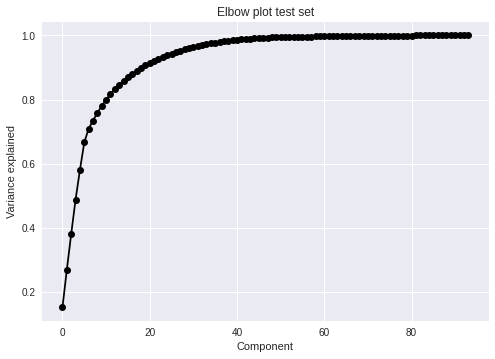

In [ ]:
pca = PCA()
pca.fit_transform(X_SVM_test_st)
plt.style.use('seaborn')
features = range(pca.n_components_)
_, ax = plt.subplots()
ax.plot(features, pca.explained_variance_ratio_.cumsum(), '-o', color='black')
ax.set(title='Elbow plot test set', 
       xlabel='Component', 
       ylabel='Variance explained');
plt.show()

In [ ]:
pca=PCA(40).fit(X_SVM_train_st)
X_SVM_train_st_pca = pca.transform(X_SVM_train_st)
X_SVM_test_st_pca = pca.transform(X_SVM_test_st)

In [ ]:
clf_svm = svm.SVC(random_state=42)
clf_svm.fit(X_SVM_train_st_pca, y_SVM_train)
clf_svm.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
print("Obtenim un",round(clf_svm.score(X_SVM_train_st_pca, y_SVM_train)*100,2),"% d'accuracy en el training set")
print("Obtenim un",round(clf_svm.score(X_SVM_test_st_pca, y_SVM_test)*100,2),"% d'accuracy en el test set")

Obtenim un 85.48 % d'accuracy en el training set
Obtenim un 83.0 % d'accuracy en el test set


In [ ]:
parameters ={'C' : [0.1,0.5,1, 10, 100]}

In [ ]:
start=time()
estimator=GridSearchCV(svm.LinearSVC(penalty='l1',random_state=0,dual=False,max_iter=10000000), parameters, cv=5,scoring='accuracy',verbose=0)
estimator.fit(X_SVM_train_st_pca, y_SVM_train)
elapsed= time() -start
print(elapsed)

2.0235679149627686


In [ ]:
print("Accuracy del training set:", round(estimator.score(X_SVM_train_st_pca, y_SVM_train)*100,2),"%")
print("Accuracy del test set:", round(estimator.score(X_SVM_test_st_pca, y_SVM_test)*100,2),"%")
print(estimator.best_params_)

Accuracy del training set: 82.85 %
Accuracy del test set: 83.3 %
{'C': 0.5}


In [ ]:
parameters ={'C' : [0.1,0.5,1, 10, 100], 'loss' : ['hinge','squared_hinge']}
scores=[0]

In [ ]:
start=time()
estimator=GridSearchCV(svm.LinearSVC(random_state=0,max_iter=10000000), parameters, cv=5,scoring='accuracy',verbose=0)
estimator.fit(X_SVM_train_st_pca, y_SVM_train)
elapsed= time() -start
print(elapsed)

580.6387357711792


In [ ]:
print("Accuracy del training set:", round(estimator.score(X_SVM_train_st_pca,y_SVM_train)*100,2),"%")
print("Accuracy del test set:", round(estimator.score(X_SVM_test_st_pca,y_SVM_test)*100,2),"%")
print(estimator.best_params_)

Accuracy del training set: 82.88 %
Accuracy del test set: 83.5 %
{'C': 0.5, 'loss': 'squared_hinge'}


In [ ]:
parameters ={'gamma':['scale','auto',1,0.1,0.01,0.001,0.0001],'C' : [0.1,0.5,1, 10, 100]}

In [ ]:
start=time()
estimator=GridSearchCV(svm.SVC(), parameters, cv=5,scoring='accuracy',verbose=0)
estimator.fit(X_SVM_train_st_pca, y_SVM_train)
elapsed= time() -start
print(elapsed)

109.73567700386047


In [ ]:
print("Accuracy del training set:", round(estimator.score(X_SVM_train_st_pca, y_SVM_train)*100,2),"%")
print("Accuracy del test set:", round(estimator.score(X_SVM_test_st_pca,y_SVM_test)*100,2),"%")
print(estimator.best_params_)

Accuracy del training set: 85.12 %
Accuracy del test set: 82.5 %
{'C': 10, 'gamma': 'auto'}


In [ ]:
parameters ={'gamma':['scale','auto',1,0.1,0.01,0.001,0.0001],'C' : [0.1,0.5,1, 10, 100]}

In [ ]:
start=time()
estimator=GridSearchCV(svm.SVC(kernel='sigmoid'), parameters, cv=5,scoring='accuracy',verbose=0)
estimator.fit(X_SVM_train_st_pca, y_SVM_train)
elapsed= time() -start
print(elapsed)

116.10612535476685


In [ ]:
print("Accuracy del training set:", round(estimator.score(X_SVM_train_st_pca, y_SVM_train)*100,2),"%")
print("Accuracy del test set:", round(estimator.score(X_SVM_test_st_pca,y_SVM_test)*100,2),"%")
print(estimator.best_params_)

Accuracy del training set: 81.82 %
Accuracy del test set: 82.3 %
{'C': 10, 'gamma': 0.01}


# CONCLUSIONS

De tots els models avaluats, l'únic que supera el 85% d'accuracy al conjunt d'entrenament és el SVM amb kernel RBF. És per tant el que té més overfitting, ja que la puntuació en el conjunt de validació no destaca. En quant a accuracy al conjunt de validació, els que presenten millors resultats són els kernels lineals. L'estimador SVM és el que dóna millors resultats en aquest dataset. 


El millor model és el **SVM amb kernel lineal i regularització l1**, ja que presenta un accuracy molt similar en ambdós conjunts, pràcticament la més alta al conjunt de validació amb un 83.4%. A més té una precisió superior al 80% per ambdues classes, del 86.46% en la classe <=50k i del 80.18% en la >50k.
